## SetUp

In [1]:
#!pip install evaluate datasets transformers accelerate==1.9.0 wandb safetensors==0.4.3

In [ ]:
#!pip install evaluate datasets transformers accelerate==1.9.0 wandb safetensors==0.4.3

In [27]:
#!pip install -q datasets evaluate
#!pip install -q sacrebleu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Timing performance sur example de model

In [14]:
import psutil

print("CPU cores:", psutil.cpu_count(logical=True))
print("RAM total:", round(psutil.virtual_memory().total / 1024**3, 2), "GB")

CPU cores: 8
RAM total: 30.99 GB


In [19]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import time

# ----------- 1. Forcer CPU et nombre de threads -----------
device = torch.device("cpu")
torch.set_num_threads(2)  # Limite PyTorch à 2 CPU
print("Using device:", device)
print("Num threads:", torch.get_num_threads())

# ----------- 2. Charger le modèle et le tokenizer -----------
model_name = "vennify/t5-base-grammar-correction"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

# ----------- 3. Phrase à corriger -----------
text = "This sentences has has bads grammar."
input_text = "grammar: " + text

# Tokenization
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# ----------- 4. Génération avec mesure du temps -----------
with torch.inference_mode():  # économise la mémoire
    start_time = time.time()
    outputs = model.generate(
        **inputs,
        num_beams=5,
        min_length=1
    )
    end_time = time.time()

# Décodage du texte
corrected_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Corrected:", corrected_text)
print(f"Inference time: {end_time - start_time:.3f} seconds")


Using device: cpu
Num threads: 1
Corrected: This sentence has bad grammar.
Inference time: 0.782 seconds


In [18]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import time

# ----------- 1. Forcer CPU et nombre de threads -----------
device = torch.device("cpu")
torch.set_num_threads(4)  # Limite PyTorch à 2 CPU
print("Using device:", device)
print("Num threads:", torch.get_num_threads())

# ----------- 2. Charger le modèle et le tokenizer -----------
model_name = "vennify/t5-base-grammar-correction"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

# ----------- 3. Phrase à corriger -----------
text = "This sentences has has bads grammar."
input_text = "grammar: " + text

# Tokenization
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# ----------- 4. Génération avec mesure du temps -----------
with torch.inference_mode():  # économise la mémoire
    start_time = time.time()
    outputs = model.generate(
        **inputs,
        num_beams=5,
        min_length=1
    )
    end_time = time.time()

# Décodage du texte
corrected_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Corrected:", corrected_text)
print(f"Inference time: {end_time - start_time:.3f} seconds")


Using device: cpu
Num threads: 4
Corrected: This sentence has bad grammar.
Inference time: 0.415 seconds


## Dataset Transform

In [1]:
import pandas as pd

In [8]:
df = pd.read_csv("writing_corrections_2024-12-17_17_23_54_n=1000.csv")


In [9]:
df = df[["writing_id", "activity_instructions", "writing_content", "corrected_writing"]]
df.head()

,writing_id,activity_instructions,writing_content,corrected_writing
0,f384a75d-cf08-4292-99e9-dd64ceae8088,Read Ken's email and then email Josh and Ken a...,"Ken,\n\nI appreciate the thorough summary of o...","Ken,\n\nI appreciate the thorough summary of o..."
1,296465d9-5d4f-402a-83dc-dd89c8766539,Think about a business situation you have been...,A client expressed dissatisfaction with a dela...,A client expressed dissatisfaction with the de...
2,cc271da5-1d25-4255-8f37-376b2591b2b4,"You're going to read a hotel review, then writ...",I recently stayed at the Grandview Hotel in Pa...,I recently stayed at the Grandview Hotel in Pa...
3,58180ef5-c741-45c3-9720-1c69b30b4d4f,Write a paragraph describing how robots are be...,"Robotics is advancing more and more in Brazil,...","Robotics is advancing rapidly in Brazil, both ..."
4,a0a79b53-734d-465a-ada7-89fa5545525e,Write a paragraph about your favorite holiday ...,My favorite holiday is Christimas. Christimas ...,My favorite holiday is Christmas. Christmas is...


In [24]:
from datasets import Dataset, DatasetDict

from datasets import Dataset, DatasetDict

df_hf = df.rename(columns={
    "writing_id": "_id",
    "activity_instructions": "task",
    "writing_content": "src",
    "corrected_writing": "tgt"
})

dataset = Dataset.from_pandas(df_hf, preserve_index=False)

split1 = dataset.train_test_split(test_size=0.3, seed=42)  # 70% train, 30% remaining
split2 = split1['test'].train_test_split(test_size=0.5, seed=42)  # 15% val, 15% test

ds_ft = DatasetDict({
    "train": split1['train'],
    "validation": split2['train'],
    "test": split2['test']
})

print(ds_ft)

DatasetDict({
    train: Dataset({
        features: ['_id', 'task', 'src', 'tgt'],
        num_rows: 700
    })
    validation: Dataset({
        features: ['_id', 'task', 'src', 'tgt'],
        num_rows: 150
    })
    test: Dataset({
        features: ['_id', 'task', 'src', 'tgt'],
        num_rows: 150
    })
})


## SFT

In [25]:
MODELNAME = "t5-base"
PREFIX = "grammar: "

In [14]:
import torch
training_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
training_device
import numpy as np

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [15]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained(MODELNAME)
model = T5ForConditionalGeneration.from_pretrained(MODELNAME)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


## Dataset

In [16]:
from datasets import load_dataset

#ds = load_dataset("dim/grammarly_coedit")

#print(ds)

"""
DatasetDict({
    train: Dataset({
        features: ['_id', 'task', 'src', 'tgt'],
        num_rows: 82466
    })
})
"""

#print(ds["train"][0])

"""
{'_id': '0', 'task': 'gec', 
'src': 'Remove all grammatical errors from this text: For example, countries with a lot of deserts can terraform their desert to increase their habitable land and using irrigation to provide clean water to the desert.', 
'tgt': 'For example, countries with a lot of deserts can transform their desert to increase their habitable land and use irrigation to provide clean water to the desert.'}
"""

"\n{'_id': '0', 'task': 'gec', \n'src': 'Remove all grammatical errors from this text: For example, countries with a lot of deserts can terraform their desert to increase their habitable land and using irrigation to provide clean water to the desert.', \n'tgt': 'For example, countries with a lot of deserts can transform their desert to increase their habitable land and use irrigation to provide clean water to the desert.'}\n"

In [26]:
def fix(example):
    # Remove the numeric prefix before colon
    string_list = example["src"].split(":")
    text = " ".join(string_list[1:]).strip()
    example["src"] = text
    return example

# Apply the cleaning function
ds_ft["train"] = ds_ft["train"].map(fix)

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

In [27]:
print(ds_ft["train"][0])

{'_id': '92aa6cc2-3cf0-4e82-8fd0-30929e384c8b', 'task': "You're going to reply to Alice's blog post about cross-cultural communication. Give advice about your own culture. Type in the input box. Write 50-75 words. Use your own words where possible.", 'src': '', 'tgt': "I work for a global company. I've been lucky enough to travel around the world and do business with many different people in many different countries. What I've learned is that understanding cross-cultural differences is critical for successful communication.\n\nFor example, people from my culture are apt to maintain eye contact in a conversation. In some countries I've visited, however, maintaining eye contact can be considered rather rude or even aggressive. "}


🔤 Max src length: 2308
🔤 Max tgt length: 8087
📊 95th percentile src length: 241.0
📊 95th percentile tgt length: 319.04999999999995


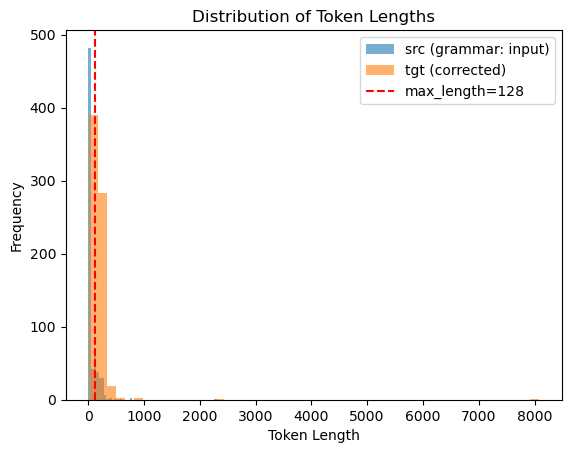

'\n🔤 Max src length: 199\n🔤 Max tgt length: 199\n📊 95th percentile src length: 52.0\n📊 95th percentile tgt length: 49.0\n'

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate lengths
src_lengths = [len(tokenizer.encode("grammar: " + x["src"])) for x in ds_ft["train"]]
tgt_lengths = [len(tokenizer.encode(x["tgt"])) for x in ds_ft["train"]]

# Stats
print(f"🔤 Max src length: {max(src_lengths)}")
print(f"🔤 Max tgt length: {max(tgt_lengths)}")
print(f"📊 95th percentile src length: {np.percentile(src_lengths, 95)}")
print(f"📊 95th percentile tgt length: {np.percentile(tgt_lengths, 95)}")

# Optional: Plot histograms
plt.hist(src_lengths, bins=50, alpha=0.6, label='src (grammar: input)')
plt.hist(tgt_lengths, bins=50, alpha=0.6, label='tgt (corrected)')
plt.axvline(128, color='red', linestyle='--', label='max_length=128')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Token Lengths')
plt.show()

"""
🔤 Max src length: 199
🔤 Max tgt length: 199
📊 95th percentile src length: 52.0
📊 95th percentile tgt length: 49.0
"""

In [29]:
dataset = ds_ft["train"].train_test_split(test_size=0.1, seed=42)
train_ds = ds_ft["train"]
val_ds = ds_ft["validation"]

In [30]:
def preprocess(example):
    input_text = PREFIX + example["src"]
    target_text = example["tgt"]
    model_inputs = tokenizer(input_text, truncation=True, padding="max_length", max_length=256)
    labels = tokenizer(target_text, truncation=True, padding="max_length", max_length=256)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train = train_ds.map(preprocess, batched=False)
tokenized_val = val_ds.map(preprocess, batched=False)

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [31]:
import evaluate
import sacrebleu
import numpy as np

exact_match = evaluate.load("exact_match")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Exact match
    em = exact_match.compute(predictions=decoded_preds, references=decoded_labels)["exact_match"]

    # BLEU via sacrebleu
    bleu = sacrebleu.corpus_bleu(decoded_preds, [decoded_labels])
    bleu_score = bleu.score

    return {"exact_match": em, "bleu": bleu_score}

In [32]:
import torch
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="./t5-grammar-corrector",
    do_eval=True,
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

trainer = Seq2SeqTrainer(
    model=model,                             # The model to train
    args=training_args,                      # Training configurations
    train_dataset=tokenized_train,           # Tokenized training data
    eval_dataset=tokenized_val,              # Tokenized validation data
    tokenizer=tokenizer,                     # Tokenizer (for padding, decoding, etc.)
)

trainer.train()

"""
Epoch Training Loss Validation Loss
1 0.185000 0.165196
2 0.178100 0.161055
3 0.171300 0.160168
TrainOutput(global_step=27834, training_loss=0.1946344326956995, metrics={'train_runtime': 2212.8832, 'train_samples_per_second': 100.619, 'train_steps_per_second': 12.578, 'total_flos': 7533699872587776.0, 'train_loss': 0.1946344326956995, 'epoch': 3.0})
"""

/tmp/ipykernel_25414/1404983597.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss


"\nEpoch Training Loss Validation Loss\n1 0.185000 0.165196\n2 0.178100 0.161055\n3 0.171300 0.160168\nTrainOutput(global_step=27834, training_loss=0.1946344326956995, metrics={'train_runtime': 2212.8832, 'train_samples_per_second': 100.619, 'train_steps_per_second': 12.578, 'total_flos': 7533699872587776.0, 'train_loss': 0.1946344326956995, 'epoch': 3.0})\n"

In [33]:
model.save_pretrained("./t5-grammar-corrector")
tokenizer.save_pretrained("./t5-grammar-corrector")

"""
('./t5-grammar-corrector/tokenizer_config.json',
 './t5-grammar-corrector/special_tokens_map.json',
 './t5-grammar-corrector/spiece.model',
 './t5-grammar-corrector/added_tokens.json')
"""

"\n('./t5-grammar-corrector/tokenizer_config.json',\n './t5-grammar-corrector/special_tokens_map.json',\n './t5-grammar-corrector/spiece.model',\n './t5-grammar-corrector/added_tokens.json')\n"

In [34]:
eval_results = trainer.evaluate()
print("📊 Evaluation Results:", eval_results)

""" 
[1031/1031 00:25]
📊 Evaluation Results: {'eval_loss': 0.1601683497428894, 'eval_runtime': 25.8443, 'eval_samples_per_second': 319.104, 'eval_steps_per_second': 39.893, 'epoch': 3.0}
"""

📊 Evaluation Results: {'eval_loss': 0.34969887137413025, 'eval_runtime': 1.2431, 'eval_samples_per_second': 120.663, 'eval_steps_per_second': 15.284, 'epoch': 3.0}


" \n[1031/1031 00:25]\n📊 Evaluation Results: {'eval_loss': 0.1601683497428894, 'eval_runtime': 25.8443, 'eval_samples_per_second': 319.104, 'eval_steps_per_second': 39.893, 'epoch': 3.0}\n"

## Inference 

In [37]:
model = T5ForConditionalGeneration.from_pretrained("./t5-grammar-corrector")
tokenizer = T5Tokenizer.from_pretrained("./t5-grammar-corrector")

def correct_grammar(text: str):
    input_text = f"grammar: {text}"
    input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True)

    # Move to GPU if available
    input_ids = input_ids.to(model.device)

    output_ids = model.generate(input_ids, max_length=256, num_beams=4)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

"""

❌ Original:  He go to school every day.
✅ Corrected: He goes to school every day.
"""

'\n\n❌ Original:  He go to school every day.\n✅ Corrected: He goes to school every day.\n'

In [38]:
# Try on a sample sentence
test_sentence = '''
Ken, I appreciate the thorough summary of our situation. Here's a potential third option that might balance the pros and cons of both our current ideas: We could consider a mixed model where we maintain a smaller downtown showroom primarily for consultations and initial measurements, but move the production facility to a more cost-effective location. This way, we can still benefit from our established presence and long-term customer base in the fashionable district while significantly reducing our operational costs.
The showroom can serve as a sleek, appointment-only boutique where clients can enjoy personalized service in a more exclusive setting, thus preserving the close relationships we've built. Meanwhile, the production move will enable us to cut costs and potentially invest in a more robust online presence, enhancing our web platform for better accessibility and convenience.

This hybrid approach might provide us with the flexibility we need to manage costs while still maintaining a high level of customer service and engagement.

Looking forward to your thoughts.

Best, Josh
'''

corrected = correct_grammar(test_sentence)
print(f"\n❌ Original:  {test_sentence}")
print(f"✅ Corrected: {corrected}")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



❌ Original:  
Ken, I appreciate the thorough summary of our situation. Here's a potential third option that might balance the pros and cons of both our current ideas: We could consider a mixed model where we maintain a smaller downtown showroom primarily for consultations and initial measurements, but move the production facility to a more cost-effective location. This way, we can still benefit from our established presence and long-term customer base in the fashionable district while significantly reducing our operational costs.
The showroom can serve as a sleek, appointment-only boutique where clients can enjoy personalized service in a more exclusive setting, thus preserving the close relationships we've built. Meanwhile, the production move will enable us to cut costs and potentially invest in a more robust online presence, enhancing our web platform for better accessibility and convenience.

This hybrid approach might provide us with the flexibility we need to manage costs while 